<a href="https://colab.research.google.com/github/gonzaloavellanal/eccd_assignments/blob/main/assignments/Demand%20Forecasting-student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [1]:
!pip install -q eccd_datasets pygradus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 22.7 MB/s eta 0:00:00


In [2]:
STUDENT_NAME = "Gonzalo Avellanal"
COURSE_NAME = "eccd-oct23"
EXERCISE_NAME = "demand-forecsting"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

from eccd_datasets import load_m5

from pygradus import create_exercise, check_solution

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [4]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [5]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


- **date:** Contains date entries in a YYYY-MM-DD format, indicating the specific days to which the subsequent data points correspond.

- **wm_yr_wk:** Looks like a code that possibly stands for "Walmart year-week". It's an identifier for a specific week within a specific year in Walmart's fiscal calendar.

- **weekday:** The day of the week.

- **wday:** Appears to be a numerical representation of the weekday, with numbers likely ranging from 1 (Sunday) to 7 (Saturday).

- **month:** The month of the year, numerically represented.

- **year:** The year for the corresponding date.

- **d:** A shorthand notation for the day, likely corresponding to a specific day in the dataset, starting from "d_1" and so on. This is a common format in sales datasets where sales data is provided for each day.

- **event_name_1, event_type_1, event_name_2, event_type_2:** These columns are probably meant to record information about special events that could affect sales, like holidays or sales events. The "None" entries suggest that there is no event on those days. The dataset seems to allow for the possibility of two events occurring on the same day.

- **snap_CA, snap_TX, snap_WI:** These columns indicate whether a SNAP food assistance program purchase is allowed on that day in the respective states (California, Texas, Wisconsin). A "1" indicates that SNAP purchases are allowed, and a "0" means they are not. This is relevant because SNAP purchase eligibility can significantly affect sales of certain products.

In [6]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


- **id:** This is a unique identifier for each row of the dataset, which seems to represent a time series of sales data for a specific item at a specific store.

- **item_id:** This column shows the ID of the item. It looks like it's part of a larger category described by "dept_id" and "cat_id".

- **dept_id:** The department to which the item belongs, in this case, "HOBBIES".

- **cat_id:** The category of the item, which is also "HOBBIES" here.

- **store_id:** This indicates the specific store where the item is sold, "CA_1" suggesting it is store number 1 in California.

- **state_id:** The state where the store is located, "CA" indicating California.

- **d_1, d_2, d_3, ..., d_1913**: These columns represent the sales data for each item for specific days. Each "d_x" column corresponds to a day in the dataset, with the "d_" prefix likely indicating "day" and the number representing the sequential order of the days in the dataset. The numbers in these columns are the sales counts for the item on that day.

In [7]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [27]:
import pandas as pd

def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """
    #Paso 1: filtro "df_sales" por el id que le pasamos a la función
    item_sales = sales[sales['id'] == id_]

    #Paso 2: empiezo a transformar a un formato largo
    item_sales_long = item_sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                                      var_name='d', value_name='units_sold')
    #con: var_name='d' le decimos que cree una nueva columna en este nuevo df
    #con: id_vars le especificamos las columnas que queremos que deje en el df y que no van a ser melteadas.
    #con: value_name definimos una nueva columna que va a tener la cantidad de ventas de ese item para cada día

    #Paso 3: Mergeo con el df_calendar
    item_sales_long = item_sales_long.merge(calendar, how='left', left_on='d', right_on='d')

    #Paso 4: Mergeo con el df_prices
    item_sales_long = item_sales_long.merge(prices, how='left', on=['item_id', 'wm_yr_wk'])

    #Paso 5: devuelvo el df final
    return item_sales_long

In [28]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(2916, 23)


,id,item_id,dept_id,cat_id,store_id_x,state_id,d,units_sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id_y,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,...,2011,None,None,None,None,1,1,0,NaN,NaN
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,...,2011,None,None,None,None,1,0,1,NaN,NaN


In [23]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 2915
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2916 non-null   object 
 1   item_id       2916 non-null   object 
 2   dept_id       2916 non-null   object 
 3   cat_id        2916 non-null   object 
 4   store_id_x    2916 non-null   object 
 5   state_id      2916 non-null   object 
 6   d             2916 non-null   object 
 7   units_sold    2916 non-null   int64  
 8   date          2916 non-null   object 
 9   wm_yr_wk      2916 non-null   int64  
 10  weekday       2916 non-null   object 
 11  wday          2916 non-null   int64  
 12  month         2916 non-null   int64  
 13  year          2916 non-null   int64  
 14  event_name_1  232 non-null    object 
 15  event_type_1  232 non-null    object 
 16  event_name_2  6 non-null      object 
 17  event_type_2  6 non-null      object 
 18  snap_CA       2916 non-null 

In [33]:
df_id.describe(include="all")

,id,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id_y,sell_price
count,2916,2916.000000,2916,232,232,6,6,2916.000000,2916.000000,2916.000000,2020,2020.000000
unique,1,NaN,1913,30,4,4,2,NaN,NaN,NaN,2,NaN
top,HOBBIES_1_001_CA_1_validation,NaN,2013-09-11,SuperBowl,National,OrthodoxEaster,Cultural,NaN,NaN,NaN,CA_1,NaN
freq,2916,NaN,2,9,79,2,4,NaN,NaN,NaN,1017,NaN
mean,NaN,0.411180,NaN,NaN,NaN,NaN,NaN,0.329218,0.329218,0.329218,NaN,8.274673
std,NaN,0.758711,NaN,NaN,NaN,NaN,NaN,0.470010,0.470010,0.470010,NaN,0.134245
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
25%,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
50%,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
75%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,8.260000


In [24]:
df_id["units_sold"].value_counts()

0    2075
1     581
2     188
3      50
4      18
5       4
Name: units_sold, dtype: int64

Text(0, 0.5, '# Units sold')

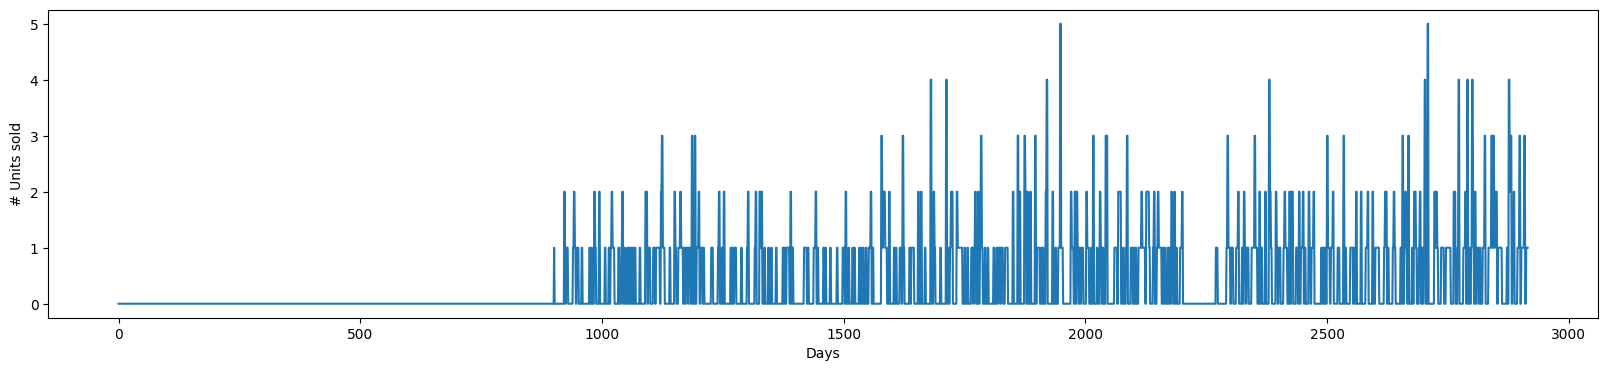

In [25]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [29]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id_x", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,id,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id_y,sell_price
0,HOBBIES_1_001_CA_1_validation,0,2011-01-29,None,None,None,None,0,0,0,NaN,NaN
1,HOBBIES_1_001_CA_1_validation,0,2011-01-30,None,None,None,None,0,0,0,NaN,NaN
2,HOBBIES_1_001_CA_1_validation,0,2011-01-31,None,None,None,None,0,0,0,NaN,NaN
3,HOBBIES_1_001_CA_1_validation,0,2011-02-01,None,None,None,None,1,1,0,NaN,NaN
4,HOBBIES_1_001_CA_1_validation,0,2011-02-02,None,None,None,None,1,0,1,NaN,NaN


In [30]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 2915
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2916 non-null   object 
 1   units_sold    2916 non-null   int64  
 2   date          2916 non-null   object 
 3   event_name_1  232 non-null    object 
 4   event_type_1  232 non-null    object 
 5   event_name_2  6 non-null      object 
 6   event_type_2  6 non-null      object 
 7   snap_CA       2916 non-null   int64  
 8   snap_TX       2916 non-null   int64  
 9   snap_WI       2916 non-null   int64  
 10  store_id_y    2020 non-null   object 
 11  sell_price    2020 non-null   float64
dtypes: float64(1), int64(4), object(7)
memory usage: 296.2+ KB


In [32]:
df_id.describe(include="all")

,id,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id_y,sell_price
count,2916,2916.000000,2916,232,232,6,6,2916.000000,2916.000000,2916.000000,2020,2020.000000
unique,1,NaN,1913,30,4,4,2,NaN,NaN,NaN,2,NaN
top,HOBBIES_1_001_CA_1_validation,NaN,2013-09-11,SuperBowl,National,OrthodoxEaster,Cultural,NaN,NaN,NaN,CA_1,NaN
freq,2916,NaN,2,9,79,2,4,NaN,NaN,NaN,1017,NaN
mean,NaN,0.411180,NaN,NaN,NaN,NaN,NaN,0.329218,0.329218,0.329218,NaN,8.274673
std,NaN,0.758711,NaN,NaN,NaN,NaN,NaN,0.470010,0.470010,0.470010,NaN,0.134245
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
25%,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
50%,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,8.260000
75%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,8.260000


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available.

In [35]:
df_id["sell_price"] = df_id["sell_price"].ffill()

- **ffill()** (forward fill): This method propagates the last valid observation (non-null value) forward to the next null observation in the DataFrame or Series. It's used to fill in missing values with the most recent known value that appears before the gap. If the missing value is at the beginning of the series, it remains unfilled since there is no prior value to carry forward.

- **bfill()** (backward fill): Conversely, this method fills missing values with the next valid observation that comes after the gap. It works backward from the point of the missing data and propagates the first known value that comes after the missing value. If the missing value is at the end of the series, it remains unfilled because there is no subsequent value to fill backwards from.

In [36]:
df_id.head()

,id,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id_y,sell_price
0,HOBBIES_1_001_CA_1_validation,0,2011-01-29,None,None,None,None,0,0,0,NaN,9.58
1,HOBBIES_1_001_CA_1_validation,0,2011-01-30,None,None,None,None,0,0,0,NaN,9.58
2,HOBBIES_1_001_CA_1_validation,0,2011-01-31,None,None,None,None,0,0,0,NaN,9.58
3,HOBBIES_1_001_CA_1_validation,0,2011-02-01,None,None,None,None,1,1,0,NaN,9.58
4,HOBBIES_1_001_CA_1_validation,0,2011-02-02,None,None,None,None,1,0,1,NaN,9.58


In [51]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 2915
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            2916 non-null   object        
 1   units_sold    2916 non-null   int64         
 2   date          2916 non-null   datetime64[ns]
 3   event_name_1  232 non-null    object        
 4   event_type_1  232 non-null    object        
 5   event_name_2  6 non-null      object        
 6   event_type_2  6 non-null      object        
 7   snap_CA       2916 non-null   int64         
 8   snap_TX       2916 non-null   int64         
 9   snap_WI       2916 non-null   int64         
 10  store_id_y    2020 non-null   object        
 11  sell_price    2916 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 296.2+ KB


In [55]:
def build_temporal_features(date_variable: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes `date_variable` which should be a pandas datetype
    and creates several temporal features from it.

    In particular, it should create the additional columns in the dataframe

    Asume that all variables are in the range [0, x])

    `day_of_month`
    `month` (Jan = 0)
    `day_of_week` (Monday=0, Sunday= 6)
    `day_of_week_sin`
    `day_of_week_cos`
    `month_cos`
    `month_sin`
    `day_of_month_sin`
    `day_of_month_cos`
    `lag_1`
    `lag_7`

    Remember to sort the dataframe using the data variable with the most
    recent values in the bottom.

    """
    #Me aseguro que la columa date esté en formato fecha
    df[date_variable] = pd.to_datetime(df[date_variable])

    #ordeno el df por la columna date
    df = df.sort_values(by=date_variable)

    #Creo las primeras 3 columnas
    df['day_of_month'] = df[date_variable].dt.day - 1
    df['month'] = df[date_variable].dt.month - 1  #Para que Januray arranque en 0
    df['day_of_week'] = df[date_variable].dt.dayofweek  #Monday=0, Sunday=6

    #Trigonometric features
    days_in_week = 7
    months_in_year = 12
    days_in_month = df[date_variable].dt.days_in_month.max()  # Assuming 'x' is max days in month

    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / days_in_week)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / days_in_week)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / months_in_year)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / months_in_year)

    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / days_in_month)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / days_in_month)

    #Lag features
    df['lag_1'] = df['units_sold'].shift(1)
    df['lag_7'] = df['units_sold'].shift(7)

    #Fill NaN values created by lag features with appropriate method, e.g., forward fill
    #df['lag_1'] = df['lag_1'].ffill()
    #df['lag_7'] = df['lag_7'].ffill()

    return df

In [56]:
df = build_temporal_features("date" , df_id)

In [57]:
df.head()

,id,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,...,month,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,lag_1,lag_7
0,HOBBIES_1_001_CA_1_validation,0,2011-01-29,None,None,None,None,0,0,0,...,0,5,-0.974928,-0.222521,0.0,1.000000,-0.571268,0.820763,NaN,NaN
1,HOBBIES_1_001_CA_1_validation,0,2011-01-30,None,None,None,None,0,0,0,...,0,6,-0.781831,0.623490,0.0,1.000000,-0.394356,0.918958,0.0,NaN
2,HOBBIES_1_001_CA_1_validation,0,2011-01-31,None,None,None,None,0,0,0,...,0,0,0.000000,1.000000,0.0,1.000000,-0.201299,0.979530,0.0,NaN
3,HOBBIES_1_001_CA_1_validation,0,2011-02-01,None,None,None,None,1,1,0,...,1,1,0.781831,0.623490,0.5,0.866025,0.000000,1.000000,0.0,NaN
4,HOBBIES_1_001_CA_1_validation,0,2011-02-02,None,None,None,None,1,0,1,...,1,2,0.974928,-0.222521,0.5,0.866025,0.201299,0.979530,0.0,NaN


In [65]:
row = df.iloc[1020]

print(row["day_of_week"])
print(row["day_of_month"])
print(row["month_sin"])
print(row["month_cos"])
print(row["day_of_week_sin"])
print(row["day_of_week_cos"])
print(row["day_of_month_cos"])
print(row["lag_1"])
print(row["lag_7"])

assert np.allclose(row["day_of_week"], 3)
assert np.allclose(row["day_of_month"], 14)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
assert np.allclose(row["day_of_week_sin"], 0.433884)
assert np.allclose(row["day_of_week_cos"], -0.900969)
assert np.allclose(row["day_of_month_cos"], -0.874347)
assert np.allclose(row["lag_1"], 1)
assert np.allclose(row["lag_7"], 0)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

4
19
-0.8660254037844384
-0.5000000000000004
-0.433883739117558
-0.9009688679024191
-0.7587581226927911
1.0
0.0


AssertionError: ignored

# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [ ]:
y = df.pop("units_sold")
X = df.copy()

In [ ]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

# Training with a simple AR model

In [ ]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

In [ ]:
y_pred = arima_res.forecast(steps=30)[0]

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [ ]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

In [ ]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.

In [ ]:

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "Month",
		"answer": str(answer_month),
	},
	{
		"name": "Month Sin",
		"answer": str(answer_month_sin),
	},
	{
		"name": "7th Lag",
		"answer": str(answer_lag7),
	},
]


}
check_solution(proposed_solution)
